# Simple Physics Environment

## Data Collection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from d3rlpy.dataset import MDPDataset

from dataset import *

/home/camaral/miniconda3/envs/phyrl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = SimplePhyEnv(x0=np.random.randn(4,1)*2)
train_dataloader, test_dataloader = build_dataloader(*build_dataset(env))

In [6]:
sample = next(iter(train_dataloader))
print(sample[0].shape, sample[1].shape, sample[2].shape)

torch.Size([32, 5, 2]) torch.Size([32, 5, 2]) torch.Size([32, 5])


### Model Training

In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

<hr>

In [4]:
class SimplePhyEnv(gym.Env):
    def __init__(self, x0, timestep=1, mass=1):
        super(SimplePhyEnv,self).__init__()
        
        assert(x0.shape == (4,1))
        self.x0 = x0
        self.ts = timestep
        self.m = mass
        
        self.action_space = spaces.Box(low=-1, high=1,
                                       shape=(2,1))
        self.observation_space = spaces.Box(low=-np.Inf, high=np.Inf,
                                            shape=(2,1))
        
        # Initial state
        self.reset()
        # State-space representation
        self.A = np.matrix([[0,0,1,0],
                            [0,0,0,1],
                            [0,0,0,0],
                            [0,0,0,0]])
        self.B = np.matrix([[0,0],
                            [0,0],
                            [1/mass,0],
                            [0,1/mass]])
        
    def reset(self, x0=None):
        if x0 is None:
            self.x = self.x0
        else:
            self.x = x0
        return self.x[:2]
    
    def step(self, action):
        x_dot = self.A*self.x + self.B*np.matrix(action).reshape((2,1))
        self.x = self.x + x_dot*self.ts
        
        rwd = 0
        done = False
        info = None
        return self.x[:2], rwd, done, info

In [5]:
x0 = np.matrix([0,0,0,0]).T
env = SimplePhyEnv(x0)

In [7]:
from d3rlpy.dataset import MDPDataset

N_eps = int(1e3)
steps_per_eps = 50

observations = np.zeros((N_eps*steps_per_eps, env.observation_space.shape[0]))
actions = np.zeros((N_eps*steps_per_eps, env.action_space.shape[0]))
rewards = np.zeros((N_eps*steps_per_eps,))
terminals = np.zeros((N_eps*steps_per_eps,))

for e in range(N_eps):
    x0 = np.random.randn(4,1)*2 # std-dev=2
    x = env.reset(x0=x0)
    for s in range(steps_per_eps):
        ind = e*steps_per_eps + s
        observations[ind,:] = x.T
        
        a = env.action_space.sample()
        x, r, _, _  = env.step(a)
        
        actions[ind,:] = a.T
        rewards[ind] = r
    terminals[ind] = 1

In [8]:
dataset = MDPDataset(observations, actions, rewards, terminals)
dataset

In [13]:
dataset.dump('dataset.h5')

# Train Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
dataset = MDPDataset.load('dataset.h5')

batch_sz = 128
frames_per_sample = 8
obs_sz = 2

In [15]:
dir(dataset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_actions',
 '_as_tensor',
 '_device',
 '_episodes',
 '_observations',
 '_rewards',
 '_terminals',
 'actions',
 'append',
 'as_tensor',
 'build_episodes',
 'clip_reward',
 'compute_stats',
 'device',
 'discrete_action',
 'dump',
 'episodes',
 'extend',
 'get_action_size',
 'get_observation_shape',
 'is_action_discrete',
 'load',
 'observations',
 'rewards',
 'size',
 'terminals']

1000

In [ ]:
model = nn.Sequential(
            nn.Linear(obs_sz*frames_per_sample, 

In [235]:
# each episode is also splitted into d3rlpy.dataset.Transition objects
i = 0
while True:
    episode = dataset.episodes[i]
    try:
        episode[0].observation
    except:
        i += 1
        continue
    break
print(episode[0].observation)
print(episode[0].action)
print(episode[0].next_reward)
print(episode[0].next_observation)
print(episode[0].terminal)

# d3rlpy.dataset.Transition object has pointers to previous and next
# transitions like linked list.
transition = episode[0]
while transition.next_transition:
    transition = transition.next_transition

# save as HDF5
dataset.dump('dataset.h5')

# load from HDF5
new_dataset = MDPDataset.load('dataset.h5')

[0.38725169 0.13980766 0.9913461  0.68235295 0.93411169 0.19657822
 0.05354314 0.16386339 0.40950056 0.65615745 0.48569816 0.77860426
 0.93033426 0.98230863 0.49830513 0.44892168 0.57741453 0.43072029
 0.00191362 0.44433474 0.2680092  0.77339028 0.59809755 0.0543112
 0.87052729 0.77951872 0.03832554 0.47979715 0.29984391 0.70744256
 0.74544015 0.38823563 0.89027549 0.53847151 0.86108959 0.01240407
 0.52680645 0.85495319 0.69389207 0.7632495  0.92638564 0.63748443
 0.27793485 0.30904832 0.272705   0.54509637 0.22974155 0.13734808
 0.29386325 0.53909711 0.73302408 0.54726903 0.60341151 0.53949948
 0.51325103 0.21404141 0.08935906 0.85998669 0.15331682 0.13464584
 0.01559496 0.24624982 0.851238   0.91584756 0.85621223 0.81535221
 0.47779427 0.55991879 0.26435169 0.08022742 0.71685683 0.84637397
 0.86768988 0.01429139 0.00901482 0.24262108 0.3460559  0.44222129
 0.17948539 0.92131688 0.72388276 0.45755694 0.43452505 0.73885044
 0.22509168 0.22554991 0.59420081 0.24962606 0.02371849 0.13147

In [146]:
x0 = np.matrix([0,0,0,0]).T
env = SimplePhyEnv(x0)

In [186]:
env.reset()
N = int(10)
for i in range(N):
    env.step(env.action_space.sample())
env.x[:2]

matrix([[ 6294.76273262],
        [10651.2277126 ]])

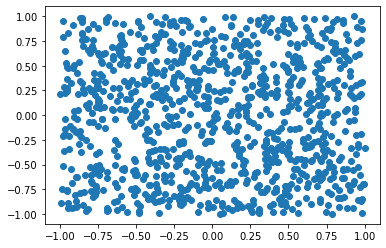

In [148]:
N = int(1e3)
x = np.zeros((N,2))
for i in range(N):
    x[i,:] = env.action_space.sample().reshape((-1,))
plt.scatter(x[:,0],x[:,1]);